In [200]:
import matplotlib.pyplot as plt # for plotting maps
import maup # mggg's library for proration, see documentation here: https://github.com/mggg/maup
import pandas as pd # standard python data library
import geopandas as gp # the geo-version of pandas
import numpy as np 
from statistics import mean, median
from pandas import read_csv

**Load datasets**

In [201]:
#Load VTD Shapefile

precincts=gp.read_file("./raw-from-files/VTD _shapefile/tl_2012_37_vtd10 (2)/tl_2012_37_vtd10.shp")

#census block shapefile

block_shp = gp.read_file("./raw-from-files/block_shapefile/tl_2019_37_tabblock10/tl_2019_37_tabblock10.shp")


#Election Data already aggregated to VTD (lacks 2012 presidential data and all 2016 election data)

vtd_election_data=read_csv("./raw-from-files/election_data/R2016_VTD.tab",delimiter='\t')

#2012 Election Data 

election_data_2012=pd.read_csv("./raw-from-files/election_data/2012 _election/results_pct_20121106.txt",delimiter=",")

#2016 Election Data 

election_data_2016=pd.read_csv("./raw-from-files/election_data/2016_election/results_pct_20161108!.txt", sep="\t",engine='python')

#MGGG Assigns districts from 2011, 2016, and new judge enacted plan 
#Taken from NCLEG Congressional Districts Shapefile

newplan= gp.read_file('./raw-from-files/district_plan/newplan/shp (3)/2016_Contingent_Congressional_Plan_Corrected.shp')

oldplan=gp.read_file('./raw-from-files/district_plan/oldplan/shp (3)/Rucho_Lewis_Congress_3.shp')

judge=gp.read_file('./raw-from-files/district_plan/judge/HB1029 3rd Edition - Shapefile/C-Goodwin-A-1-TC.shp')




In [202]:
block_keys=pd.read_csv("/Users/canuse/Downloads/Block_Level_GeoKeys.txt",sep="\t",engine='python')

In [203]:
print(block_keys)

              Block_Key  Block_Code        BG_Key  BG_Code    Tract_Key  \
0       370010201001000        1000  370010201001        1  37001020100   
1       370010201001001        1001  370010201001        1  37001020100   
2       370010201001002        1002  370010201001        1  37001020100   
3       370010201001003        1003  370010201001        1  37001020100   
4       370010201001004        1004  370010201001        1  37001020100   
...                 ...         ...           ...      ...          ...   
288982  371999604003113        3113  371999604003        3  37199960400   
288983  371999604003114        3114  371999604003        3  37199960400   
288984  371999604003115        3115  371999604003        3  37199960400   
288985  371999604003116        3116  371999604003        3  37199960400   
288986  371999604003117        3117  371999604003        3  37199960400   

        Tract_Code  Tract_Name      VTD_Key VTD_Code VTD_Name  Cnty_Key  \
0            20100      

**Load Census API**

Retrieve demographic data from Census API

To see the full list of census variables, look here: https://api.census.gov/data/2010/dec/sf1/variables.html

In [204]:
# Code chunk by Melisande Teng - VRDI 2019
variables = [
    # pop
    "P005001",
    "P005003",
    "P005004",
    "P005005",
    "P005006",
    "P005007",
    "P005008",
    "P005009",
    "P005010",
    # vap
    "P011001",
    "P011002",
    "P011005",
    "P011006",
    "P011007",
    "P011008",
    "P011009",
    "P011010",
    "P011011",
]

keys = [
    # pop
    "TOTPOP",  # these follow from above, so TOTPOP = P005001
    "NH_WHITE",
    "NH_BLACK",
    "NH_AMIN",
    "NH_ASIAN",
    "NH_NHPI",
    "NH_OTHER",
    "NH_2MORE",
    "HISP",
    # vap
    "VAP",
    "HVAP",
    "WVAP",
    "BVAP",
    "AMINVAP",
    "ASIANVAP",
    "NHPIVAP",
    "OTHERVAP",
    "2MOREVAP",
]

import requests

def counties(state_fips):
    """Inputs: state fips code
    Process: Retrieves a list of counties in the given state from the Census API.  
    Outputs: A list of county fips codes in the state. """
    resp = requests.get(
        "https://api.census.gov/data/2010/dec/sf1"
        "?get=NAME&for=county:*&in=state:{}".format(state_fips)
    )
    header, *rows = resp.json()
    county_column_index = header.index("county")
    county_fips_codes = set(row[county_column_index] for row in rows)
    return county_fips_codes


def block_data_for_county(state_fips, county_fips, variables=variables, keys=keys):
    """Inputs: state fips code, county fips code, list of variables and corresponding keys. 
    Process: formats the query to call the Census API. 
    Outputs: data for the county in a pandas dataframe. """
    url = (
        "https://api.census.gov/data/2010/dec/sf1"
        + "?get={},NAME&for=block:*".format(",".join(variables))
        + "&in=state:{}&in=county:{}&in=tract:*".format(state_fips, county_fips)
    )
    resp = requests.get(url)
    header, *rows = resp.json()
    variable_lookup = dict(zip(variables, keys))
    columns = [variable_lookup.get(column_name, column_name) for column_name in header]
    dtypes = {key: int for key in keys}
    dtypes.update({key: str for key in ["state", "county", "tract", "block"]})
    data = pd.DataFrame.from_records(rows, columns=columns).astype(dtypes)
    data["geoid"] = data["state"] + data["county"] + data["tract"] + data["block"]
    return data


def block_data_for_state(state_fips):
    """Input: state_fips
    Process: Retrieve a list of county fips codes in the state. 
        The Census API only lets you query one county at a time, so you first need the full list. 
        Then call block_data_for_county() to retrieve the data at the county level. 
    Outputs: block-level data for the state fips for the list of variables defined above. 
    """
    from tqdm.auto import tqdm
    county_fips_codes = counties(state_fips)
    return pd.concat(
        [
            block_data_for_county(state_fips, county_fips)
            for county_fips in tqdm(county_fips_codes)
        ]
    )

In [205]:
#if running script for the first time, use this chunk
#nc = block_data_for_state('37')
#nc = nc.rename(columns={"geoid": "GEOID10"})
#nc.to_csv('nc_census_2010_blocks2.csv')

Example of how you would write the census data to a csv and then re-load it so you don't have to query it every time you re-run this script


In [206]:
 nc = pd.read_csv('./nc_census_2010_blocks2.csv')
 nc = nc.astype({"GEOID10": str})
 nc.head(2)

,Unnamed: 0,TOTPOP,NH_WHITE,NH_BLACK,NH_AMIN,NH_ASIAN,NH_NHPI,NH_OTHER,NH_2MORE,HISP,...,ASIANVAP,NHPIVAP,OTHERVAP,2MOREVAP,NAME,state,county,tract,block,GEOID10
0,0,33,27,3,0,0,0,0,0,3,...,0,0,0,0,"Block 1011, Block Group 1, Census Tract 9701, ...",37,117,970100,1011,371179701001011
1,1,24,24,0,0,0,0,0,0,0,...,0,0,0,0,"Block 1012, Block Group 1, Census Tract 9701, ...",37,117,970100,1012,371179701001012


**Loading datasets to see what it is**

In [207]:
precincts.head(2)

,STATEFP10,COUNTYFP10,VTDST10,GEOID10,VTDI10,NAME10,NAMELSAD10,LSAD10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,geometry
0,37,149,WO06,37149WO06,P,WO06,Voting District WO06,V1,G5240,S,112373051,565151,+35.3132600,-082.1572357,"POLYGON ((-82.27895 35.30135, -82.27878 35.301..."
1,37,149,SA04,37149SA04,P,SA04,Voting District SA04,V1,G5240,S,85545403,38532,+35.2610918,-082.2979896,"POLYGON ((-82.35609 35.24454, -82.35517 35.244..."


In [208]:
block_shp.head(2)

,STATEFP10,COUNTYFP10,TRACTCE10,BLOCKCE10,GEOID10,NAME10,MTFCC10,UR10,UACE10,UATYPE,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,geometry
0,37,031,970602,1022,370319706021022,Block 1022,G5040,R,None,None,S,0,783785,+34.7226385,-076.8957622,"POLYGON ((-76.90105 34.72717, -76.90054 34.729..."
1,37,031,970801,2031,370319708012031,Block 2031,G5040,R,None,None,S,130921,0,+34.7305293,-077.0809037,"POLYGON ((-77.08269 34.73000, -77.08267 34.730..."


In [209]:
#block_shp = block_shp.rename(columns={"GEOID": "GEOID10"})

In [210]:
vtd_election_data.head(2)

,VTD_Key,VTD_Code,VTD_Name,PL10AA_TOT,PL10VA_TOT,EL08G_AG_D,EL08G_AG_R,EL08G_AG_TOT,EL08G_AD_D,EL08G_AD_R,...,EL12G_SPI_R,EL12G_SPI_TOT,EL12G_TR_D,EL12G_TR_R,EL12G_TR_TOT,EL14G_USS_R,EL14G_USS_D,EL14G_USS_L,EL14G_USS_WI,EL14G_USS_TOT
0,3700101,01,01,4869,3686,834,1134,1968,670,1234,...,1490,2082,653,1442,2095,1071,295,71,0,1437
1,3700102,02,02,4491,3483,936,1316,2252,627,1554,...,1725,2285,609,1694,2303,1246,313,62,2,1623


In [211]:
election_data_2012.head(2)

,county,precinct,contest_type,runoff_status,recount_status,contest,choice,winner_status,party,Election Day,One Stop,Absentee by Mail,Provisional,total votes,district
0,ALAMANCE,01_PATTERSON,S,0,0,PRESIDENT AND VICE PRESIDENT OF THE UNITED STATES,Obama/Biden,0,DEM,225,237,21,5,488,Not Found
1,ALAMANCE,02_COBLE,S,0,0,PRESIDENT AND VICE PRESIDENT OF THE UNITED STATES,Obama/Biden,0,DEM,219,184,26,0,429,Not Found


In [212]:
election_data_2016.head(2)

,County,Election Date,Precinct,Contest Group ID,Contest Type,Contest Name,Choice,Choice Party,Vote For,Election Day,One Stop,Absentee by Mail,Provisional,Total Votes
0,ALAMANCE,11/8/16,5,1385,S,US HOUSE OF REPRESENTATIVES DISTRICT 6,B. Mark Walker,REP,1,705,685,65,9,1464
1,ALAMANCE,11/8/16,2,1385,S,US HOUSE OF REPRESENTATIVES DISTRICT 6,B. Mark Walker,REP,1,954,1004,63,5,2026


**Clean up Election Datasets in Preparation to Merge with rest of the dataset**

Merge them with VTD_Key. Clean Election Data 2012 and 2016.

In [213]:
#create dictionary of county fips

my_county= {
    'ALAMANCE':'37001',
    'ALEXANDER':'37003',
    'ANSON':'37007',
    'ASHE':'37009',
    'AVERY':'37011',
    'BEAUFORT':'37013',
    'BERTIE':'37015',
    'BLADEN':'37017',
    'BRUNSWICK':'37019',
    'BUNCOMBE':'37021',
    'BURKE':'37023',
    'CABARRUS':'37025',
    'CALDWELL':'37027',
    'CAMDEN':'37029',
    'CARTERET':'37031',
    'CASWELL':'37033',
    'CATAWBA':'37035',
    'CHATHAM':'37037',
    'CHEROKEE':'37039',
    'CHOWAN':'37041',
    'CLAY':'37043',
    'CLEVELAND':'37045',
    'COLUMBUS':'37047',
    'CRAVEN':'37049',
    'CUMBERLAND':'37051',
    'CURRITICK':'37053',
    'DARE':'37055',
    'DAVIDSON':'37057',
    'DAVIE':'37059',
    'DUPLIN':'37061',
    'DURHAM':'37063',
    'EDGECOMBE':'37065',
    'FORSYTH':'37067',
    'FRANKLIN':'37069',
    'GASTON':'37071',
    'GATES':'37073',
    'GRAHAM':'37075',
    'GRANVILLE':'37077',
    'GREENE':'37079',
    'GUILFORD':'37081',
    'HALIFAX':'37083',
    'HARNETT':'37085',
    'HAYWOOD':'37087',
    'HENDERSON':'37089',
    'HERTFORD':'37091',
    'HOKE':'37093',
    'HYDE':'37095',
    'IREDELL':'37097',
    'JACKSON':'37099',
    'JOHNSTON':'37101',
    'JONES':'37103',
    'LEE':'37105',
    'LENOIR':'37107',
    'LINCOLN':'37109',
    'MCDOWELL':'37111',
    'MACON':'37113',
    'MADISON':'37115',
    'MERTIN':'37117',
    'MECKLENBURG':'37119',
    'MITCHELL':'37121',
    'MONTGOMERY':'37123',
    'MOORE':'37125',
    'NASH':'37127',
    'NEW HANOVER':'37129',
    'NORTHAMPTON':'37131',
    'ONSLOW':'37133',
    'ORANGE':'37135',
    'PAMLICO':'37137',
    'PASQUOTANK':'37139',
    'PENDER':'37141',
    'PERQUIMANS':'37143',
    'PERSON':'37145',
    'PITT':'37147',
    'POLK':'37149',
    'RANDOLPH':'37151',
    'RICHMOND':'37153',
    'ROCKINGHAM':'37157',
    'ROWAN':'37159',
    'RUTHERFORD':'37161',
    'SAMPSON':'37163',
    'SCOTLAND':'37165',
    'STANLY':'37167',
    'STOKES':'37169',
    'SURRY':'37171',
    'SWAIN':'37173',
    'TRANSYLVANIA':'37175',
    'TYRRELL':'37177',
    'UNION':'37179',
    'VANCE':'37181',
    'WAKE':'37183',
    'WARREN':'37185',
    'WASHINGTON':'37187',
    'WATAUGA':'37189',
    'WAYNE':'37191',
    'WILKES':'37193',
    'WILSON':'37195',
    'YADKIN':'37197',
    'YANCEY':'37199'
}

*Election Data 2012*

In [214]:
election_data_2012['countyID']=election_data_2012['county'].map(my_county)

In [215]:
#Preparation to string together VTD_Key
election_data_2012['countyID']=election_data_2012['countyID'].astype(str)
election_data_2012['precinct']=election_data_2012['precinct'].astype(str)
election_data_2012['precinctID']=election_data_2012['precinct'].str.zfill(2)
election_data_2012["precinctID"]=election_data_2012["precinct"].str.split("_", n=1, expand=True) 

#Combining state id, county fips, and precinct id to make VTD_Key
election_data_2012['VTD_Key']=election_data_2012['countyID']+election_data_2012['precinctID']

In [216]:
#Removing rows that has 'ONE STOP', 'ABSENTEE BY MAIL','PROVISIONAL', 'TRANSFER','CURBSIDE', 'ACCUMULATED'
#create a dataframe that has the above words

searchfor=['ABSENTEE','PROVISIONAL','TRANSFER']
#nan=['nan']
#remove rows that contains words from searchfor dataframe

election_data_2012=election_data_2012[~election_data_2012.precinct.str.contains('|'.join(searchfor))]
#election_data_2012=election_data_2012[~election_data_2012.county.str.contains('|'.join(nan))]

#Filling in empty columns in party column to write in 
#election_data_2012.loc[election_data_2012["party"].isnull(),'party']="Write_In"

In [217]:
election_data_2012.head()

,county,precinct,contest_type,runoff_status,recount_status,contest,choice,winner_status,party,Election Day,One Stop,Absentee by Mail,Provisional,total votes,district,countyID,precinctID,VTD_Key
0,ALAMANCE,01_PATTERSON,S,0,0,PRESIDENT AND VICE PRESIDENT OF THE UNITED STATES,Obama/Biden,0,DEM,225,237,21,5,488,Not Found,37001,01,3700101
1,ALAMANCE,02_COBLE,S,0,0,PRESIDENT AND VICE PRESIDENT OF THE UNITED STATES,Obama/Biden,0,DEM,219,184,26,0,429,Not Found,37001,02,3700102
2,ALAMANCE,035_BOONE 5,S,0,0,PRESIDENT AND VICE PRESIDENT OF THE UNITED STATES,Obama/Biden,0,DEM,409,362,52,9,832,Not Found,37001,035,37001035
3,ALAMANCE,03C_CENTRAL BOONE,S,0,0,PRESIDENT AND VICE PRESIDENT OF THE UNITED STATES,Obama/Biden,0,DEM,203,288,35,0,526,Not Found,37001,03C,3700103C
4,ALAMANCE,03N_NORTH BOONE,S,0,0,PRESIDENT AND VICE PRESIDENT OF THE UNITED STATES,Obama/Biden,0,DEM,380,429,70,2,881,Not Found,37001,03N,3700103N


In [218]:
office_list_2012=["PRESIDENT AND VICE PRESIDENT OF THE UNITED STATES"]
party_list=["REP","DEM","LIB","Write_In"]
election_data_2012=election_data_2012[election_data_2012['contest'].isin(office_list_2012)]
election_data_2012=election_data_2012[election_data_2012['party'].isin(party_list)]

In [219]:
#pivoting the election 2012 dataset
election_data_2012_p=pd.pivot_table(election_data_2012,index="VTD_Key",columns=["party"],values='total votes',aggfunc=sum)
election_data_2012_p.columns=["EL12G_PR_D","EL12G_PR_L","EL12G_PR_R"]
election_data_2012_p.reset_index(inplace=True)


In [220]:
election_data_2012_p.head(2)

,VTD_Key,EL12G_PR_D,EL12G_PR_L,EL12G_PR_R
0,3700101,488,16,1661
1,3700102,429,32,1936


In [221]:
election_data_2012_p.shape

(2845, 4)

In [222]:
contain_values=election_data_2012[election_data_2012['VTD_Key'].str.contains('3715920')&election_data_2012['total votes']==None]
print(contain_values)

Empty DataFrame
Columns: [county, precinct, contest_type, runoff_status , recount_status, contest, choice, winner_status, party, Election Day, One Stop, Absentee by Mail, Provisional, total votes, district, countyID, precinctID, VTD_Key]
Index: []


*Election Data 2016*

In [223]:
election_data_2016['countyID']=election_data_2016['County'].map(my_county)

In [224]:
#Preparation to string together VTD_Key
election_data_2016['countyID']=election_data_2016['countyID'].astype(str)
election_data_2016['Precinct']=election_data_2016['Precinct'].astype(str)
election_data_2016['precinctID']=election_data_2016['Precinct'].str.zfill(2)

#Combining state id, county fips, and precinct id to make VTD_Key
election_data_2016['VTD_Key']=election_data_2016['countyID']+election_data_2016['precinctID']

In [225]:
#Removing rows that has 'ONE STOP', 'ABSENTEE BY MAIL','PROVISIONAL', 'TRANSFER','CURBSIDE', 'ACCUMULATED'
#create a dataframe that has the above words

#searchfor=['ABSENTEE','PROVISIONAL','TRANSFER']
#nan=['nan']
#remove rows that contains words from searchfor dataframe

#election_data_2016=election_data_2016[~election_data_2016.Precinct.str.contains('|'.join(searchfor))]
#election_data_2016=election_data_2016[~election_data_2016.County.str.contains('|'.join(nan))]

In [226]:
#filtering the dataset

office_list_2016=["US PRESIDENT","US SENATE","NC GOVERNOR"]
party_list=["REP","DEM","LIB"]
election_data_2016=election_data_2016[election_data_2016['Contest Name'].isin(office_list_2016)]
election_data_2016=election_data_2016[election_data_2016['Choice Party'].isin(party_list)]
#election_2016=election_2016_filter[election_2016_filter['Choice'].isin(write_in)]


In [227]:
#pivoting the election 2016 dataset
election_data_2016_p=pd.pivot_table(election_data_2016,index="VTD_Key",columns=["Contest Name","Choice Party"],values='Total Votes',aggfunc=sum)
election_data_2016_p.columns=["EL16G_GV_D","EL16G_GV_L","EL16G_GV_R","EL16G_PR_D","EL16G_PR_L","EL16G_PR_R","EL16G_US_1","EL16G_US_2","EL16G_USS_"]
election_data_2016_p.reset_index(inplace=True)
election_data_2016_p.head(2)


,VTD_Key,EL16G_GV_D,EL16G_GV_L,EL16G_GV_R,EL16G_PR_D,EL16G_PR_L,EL16G_PR_R,EL16G_US_1,EL16G_US_2,EL16G_USS_
0,3700101,499,45,1806,411,50,1865,418,89,1829
1,3700102,497,39,1927,403,40,2004,396,79,1973


In [228]:
contain_values=election_data_2012[election_data_2012['VTD_Key'].str.contains('3715920')]
print(contain_values)


Empty DataFrame
Columns: [county, precinct, contest_type, runoff_status , recount_status, contest, choice, winner_status, party, Election Day, One Stop, Absentee by Mail, Provisional, total votes, district, countyID, precinctID, VTD_Key]
Index: []


In [229]:
#election_data=pd.merge(vtd_election_data,election_data_2012_p,on='VTD_Key',how='inner')


In [230]:
#election_data=pd.merge(vtd_election_data,election_data_2016_p,on='VTD_Key',how='inner')

In [320]:
election_data=pd.merge(vtd_election_data,election_data_2012_p,on='VTD_Key',how='outer',indicator='EL12')



In [321]:
election_data=pd.merge(election_data,election_data_2016_p,on='VTD_Key',how='outer',indicator='EL16')



In [322]:
election_data.shape

(4182, 92)

In [234]:
election_data.to_csv('election_data_joined.csv')

**Set Shapefile Projections**

In [235]:
precincts.crs
proj=precincts.crs
precincts=precincts.to_crs(proj)
block_shp=block_shp.to_crs(proj)

**Join Block-Level Demographic Data with Block-Level Shapefile**

In [236]:
block_joined= pd.merge(block_shp,nc,on='GEOID10',how='left',indicator='blk_jnd')


Check total population- Join is good

In [237]:
block_joined.TOTPOP.sum()

9535483

Checking if map looks right-shape looks good

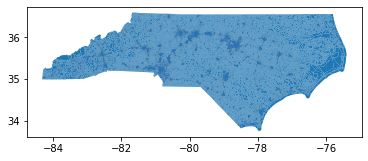

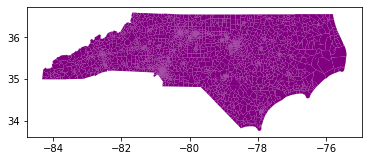

In [238]:
block_joined.plot()
precincts.plot(color='purple')

**Prorate Demographic and Voting Population Data from the Block Level to VTD using Block_Keys**

Using Block Keys because that was the method MGGG specified. 

In [239]:
block_joined.head(10)

,STATEFP10,COUNTYFP10,TRACTCE10,BLOCKCE10,GEOID10,NAME10,MTFCC10,UR10,UACE10,UATYPE,...,ASIANVAP,NHPIVAP,OTHERVAP,2MOREVAP,NAME,state,county,tract,block,blk_jnd
0,37,031,970602,1022,370319706021022,Block 1022,G5040,R,None,None,...,0,0,0,0,"Block 1022, Block Group 1, Census Tract 9706.0...",37,31,970602,1022,both
1,37,031,970801,2031,370319708012031,Block 2031,G5040,R,None,None,...,0,0,0,0,"Block 2031, Block Group 2, Census Tract 9708.0...",37,31,970801,2031,both
2,37,031,970805,1034,370319708051034,Block 1034,G5040,R,None,None,...,0,0,0,0,"Block 1034, Block Group 1, Census Tract 9708.0...",37,31,970805,1034,both
3,37,031,970801,2036,370319708012036,Block 2036,G5040,R,None,None,...,0,0,0,0,"Block 2036, Block Group 2, Census Tract 9708.0...",37,31,970801,2036,both
4,37,031,970801,2056,370319708012056,Block 2056,G5040,U,59194,C,...,0,0,0,0,"Block 2056, Block Group 2, Census Tract 9708.0...",37,31,970801,2056,both
5,37,031,970804,1008,370319708041008,Block 1008,G5040,R,None,None,...,0,0,0,0,"Block 1008, Block Group 1, Census Tract 9708.0...",37,31,970804,1008,both
6,37,031,970802,1015,370319708021015,Block 1015,G5040,U,59194,C,...,0,0,0,0,"Block 1015, Block Group 1, Census Tract 9708.0...",37,31,970802,1015,both
7,37,031,970804,2034,370319708042034,Block 2034,G5040,R,None,None,...,0,0,0,0,"Block 2034, Block Group 2, Census Tract 9708.0...",37,31,970804,2034,both
8,37,031,970804,2030,370319708042030,Block 2030,G5040,R,None,None,...,0,0,0,0,"Block 2030, Block Group 2, Census Tract 9708.0...",37,31,970804,2030,both
9,37,031,970802,1067,370319708021067,Block 1067,G5040,U,59194,C,...,0,0,0,0,"Block 1067, Block Group 1, Census Tract 9708.0...",37,31,970802,1067,both


In [240]:
block_joined = block_joined.rename(columns={"GEOID10": "Block_Key"})

In [241]:
block_joined.head(10)

,STATEFP10,COUNTYFP10,TRACTCE10,BLOCKCE10,Block_Key,NAME10,MTFCC10,UR10,UACE10,UATYPE,...,ASIANVAP,NHPIVAP,OTHERVAP,2MOREVAP,NAME,state,county,tract,block,blk_jnd
0,37,031,970602,1022,370319706021022,Block 1022,G5040,R,None,None,...,0,0,0,0,"Block 1022, Block Group 1, Census Tract 9706.0...",37,31,970602,1022,both
1,37,031,970801,2031,370319708012031,Block 2031,G5040,R,None,None,...,0,0,0,0,"Block 2031, Block Group 2, Census Tract 9708.0...",37,31,970801,2031,both
2,37,031,970805,1034,370319708051034,Block 1034,G5040,R,None,None,...,0,0,0,0,"Block 1034, Block Group 1, Census Tract 9708.0...",37,31,970805,1034,both
3,37,031,970801,2036,370319708012036,Block 2036,G5040,R,None,None,...,0,0,0,0,"Block 2036, Block Group 2, Census Tract 9708.0...",37,31,970801,2036,both
4,37,031,970801,2056,370319708012056,Block 2056,G5040,U,59194,C,...,0,0,0,0,"Block 2056, Block Group 2, Census Tract 9708.0...",37,31,970801,2056,both
5,37,031,970804,1008,370319708041008,Block 1008,G5040,R,None,None,...,0,0,0,0,"Block 1008, Block Group 1, Census Tract 9708.0...",37,31,970804,1008,both
6,37,031,970802,1015,370319708021015,Block 1015,G5040,U,59194,C,...,0,0,0,0,"Block 1015, Block Group 1, Census Tract 9708.0...",37,31,970802,1015,both
7,37,031,970804,2034,370319708042034,Block 2034,G5040,R,None,None,...,0,0,0,0,"Block 2034, Block Group 2, Census Tract 9708.0...",37,31,970804,2034,both
8,37,031,970804,2030,370319708042030,Block 2030,G5040,R,None,None,...,0,0,0,0,"Block 2030, Block Group 2, Census Tract 9708.0...",37,31,970804,2030,both
9,37,031,970802,1067,370319708021067,Block 1067,G5040,U,59194,C,...,0,0,0,0,"Block 1067, Block Group 1, Census Tract 9708.0...",37,31,970802,1067,both


In [242]:
block_keys.head(10)

,Block_Key,Block_Code,BG_Key,BG_Code,Tract_Key,Tract_Code,Tract_Name,VTD_Key,VTD_Code,VTD_Name,Cnty_Key,Cnty_Code,Cnty_Name,Place_Key,Place_Code,Place_Name,ZCTA5
0,370010201001000,1000,370010201001,1,37001020100,20100,201.0,3700112W,12W,12W,37001,1,Alamance,3709060.0,9060.0,Burlington,27215.0
1,370010201001001,1001,370010201001,1,37001020100,20100,201.0,3700112W,12W,12W,37001,1,Alamance,3709060.0,9060.0,Burlington,27215.0
2,370010201001002,1002,370010201001,1,37001020100,20100,201.0,3700112W,12W,12W,37001,1,Alamance,3709060.0,9060.0,Burlington,27215.0
3,370010201001003,1003,370010201001,1,37001020100,20100,201.0,3700112W,12W,12W,37001,1,Alamance,3709060.0,9060.0,Burlington,27217.0
4,370010201001004,1004,370010201001,1,37001020100,20100,201.0,3700112W,12W,12W,37001,1,Alamance,3709060.0,9060.0,Burlington,27215.0
5,370010201001005,1005,370010201001,1,37001020100,20100,201.0,3700112W,12W,12W,37001,1,Alamance,3709060.0,9060.0,Burlington,27215.0
6,370010201001006,1006,370010201001,1,37001020100,20100,201.0,3700112W,12W,12W,37001,1,Alamance,3709060.0,9060.0,Burlington,27215.0
7,370010201001007,1007,370010201001,1,37001020100,20100,201.0,3700112W,12W,12W,37001,1,Alamance,3709060.0,9060.0,Burlington,27215.0
8,370010201001008,1008,370010201001,1,37001020100,20100,201.0,3700112W,12W,12W,37001,1,Alamance,3709060.0,9060.0,Burlington,27215.0
9,370010201001009,1009,370010201001,1,37001020100,20100,201.0,3700112W,12W,12W,37001,1,Alamance,3709060.0,9060.0,Burlington,27215.0


In [243]:
block_joined["Block_Key"]=block_joined["Block_Key"].astype(int)

In [244]:
block_joined.shape

(288987, 41)

In [245]:
block_keys.shape

(288987, 17)

In [246]:
block_keys["Block_Key"]=block_keys["Block_Key"].astype(int)

In [247]:
block_joined2=pd.merge(block_joined,block_keys,on='Block_Key',how='outer',indicator=True)

In [248]:
block_joined2.head(10)

,STATEFP10,COUNTYFP10,TRACTCE10,BLOCKCE10,Block_Key,NAME10,MTFCC10,UR10,UACE10,UATYPE,...,VTD_Code,VTD_Name,Cnty_Key,Cnty_Code,Cnty_Name,Place_Key,Place_Code,Place_Name,ZCTA5,_merge
0,37,031,970602,1022,370319706021022,Block 1022,G5040,R,None,None,...,BCRK,BCRK,37031,31,Carteret,NaN,NaN,NaN,28570.0,both
1,37,031,970801,2031,370319708012031,Block 2031,G5040,R,None,None,...,PELE,PELE,37031,31,Carteret,3751040.0,51040.0,Peletier,28584.0,both
2,37,031,970805,1034,370319708051034,Block 1034,G5040,R,None,None,...,PELE,PELE,37031,31,Carteret,3751040.0,51040.0,Peletier,28584.0,both
3,37,031,970801,2036,370319708012036,Block 2036,G5040,R,None,None,...,PELE,PELE,37031,31,Carteret,3751040.0,51040.0,Peletier,28584.0,both
4,37,031,970801,2056,370319708012056,Block 2056,G5040,U,59194,C,...,PELE,PELE,37031,31,Carteret,NaN,NaN,NaN,28584.0,both
5,37,031,970804,1008,370319708041008,Block 1008,G5040,R,None,None,...,BOGU,BOGU,37031,31,Carteret,NaN,NaN,NaN,28570.0,both
6,37,031,970802,1015,370319708021015,Block 1015,G5040,U,59194,C,...,CCCP,CCCP,37031,31,Carteret,3711340.0,11340.0,Cedar Point,28584.0,both
7,37,031,970804,2034,370319708042034,Block 2034,G5040,R,None,None,...,BOGU,BOGU,37031,31,Carteret,NaN,NaN,NaN,28570.0,both
8,37,031,970804,2030,370319708042030,Block 2030,G5040,R,None,None,...,BOGU,BOGU,37031,31,Carteret,NaN,NaN,NaN,28570.0,both
9,37,031,970802,1067,370319708021067,Block 1067,G5040,U,59194,C,...,CCCP,CCCP,37031,31,Carteret,NaN,NaN,NaN,28584.0,both


In [249]:
block_joined2.columns.unique()

Index(['STATEFP10', 'COUNTYFP10', 'TRACTCE10', 'BLOCKCE10', 'Block_Key',
       'NAME10', 'MTFCC10', 'UR10', 'UACE10', 'UATYPE', 'FUNCSTAT10',
       'ALAND10', 'AWATER10', 'INTPTLAT10', 'INTPTLON10', 'geometry',
       'Unnamed: 0', 'TOTPOP', 'NH_WHITE', 'NH_BLACK', 'NH_AMIN', 'NH_ASIAN',
       'NH_NHPI', 'NH_OTHER', 'NH_2MORE', 'HISP', 'VAP', 'HVAP', 'WVAP',
       'BVAP', 'AMINVAP', 'ASIANVAP', 'NHPIVAP', 'OTHERVAP', '2MOREVAP',
       'NAME', 'state', 'county', 'tract', 'block', 'blk_jnd', 'Block_Code',
       'BG_Key', 'BG_Code', 'Tract_Key', 'Tract_Code', 'Tract_Name', 'VTD_Key',
       'VTD_Code', 'VTD_Name', 'Cnty_Key', 'Cnty_Code', 'Cnty_Name',
       'Place_Key', 'Place_Code', 'Place_Name', 'ZCTA5', '_merge'],
      dtype='object')

In [250]:
block_joined2.shape

(288987, 58)

In [251]:
list(block_joined2.columns)

['STATEFP10',
 'COUNTYFP10',
 'TRACTCE10',
 'BLOCKCE10',
 'Block_Key',
 'NAME10',
 'MTFCC10',
 'UR10',
 'UACE10',
 'UATYPE',
 'FUNCSTAT10',
 'ALAND10',
 'AWATER10',
 'INTPTLAT10',
 'INTPTLON10',
 'geometry',
 'Unnamed: 0',
 'TOTPOP',
 'NH_WHITE',
 'NH_BLACK',
 'NH_AMIN',
 'NH_ASIAN',
 'NH_NHPI',
 'NH_OTHER',
 'NH_2MORE',
 'HISP',
 'VAP',
 'HVAP',
 'WVAP',
 'BVAP',
 'AMINVAP',
 'ASIANVAP',
 'NHPIVAP',
 'OTHERVAP',
 '2MOREVAP',
 'NAME',
 'state',
 'county',
 'tract',
 'block',
 'blk_jnd',
 'Block_Code',
 'BG_Key',
 'BG_Code',
 'Tract_Key',
 'Tract_Code',
 'Tract_Name',
 'VTD_Key',
 'VTD_Code',
 'VTD_Name',
 'Cnty_Key',
 'Cnty_Code',
 'Cnty_Name',
 'Place_Key',
 'Place_Code',
 'Place_Name',
 'ZCTA5',
 '_merge']

In [252]:
block_joined2.VTD_Key.unique()

array(['37031BCRK', '37031PELE', '37031BOGU', ..., '37095OCK', '3712107',
       '37083RR-5'], dtype=object)

In [253]:
block_joined.shape

(288987, 41)

In [254]:
precincts.shape

(2692, 15)

In [365]:
block_joined2.shape

(288987, 58)

**Pivot block_joined2**

In [366]:
block_joined2_p=pd.pivot_table(block_joined2,index="VTD_Key",aggfunc=sum)
block_joined2_p.reset_index(inplace=True)

**Assigning District Plans from 2011,2016, and judge's plans**

Taken from ['https://www.ncleg.gov/Redistricting']

***Enacted 2016***

In [256]:
print(newplan)

    District                                           geometry
0          1  POLYGON ((829739.478 313389.067, 830140.035 31...
1          2  POLYGON ((673812.747 279062.239, 674507.854 27...
2          3  POLYGON ((896316.545 315360.015, 897124.145 30...
3          4  POLYGON ((592204.289 276551.429, 592204.469 27...
4          5  POLYGON ((371866.217 318006.836, 372363.429 31...
5          6  POLYGON ((519662.791 310255.858, 519675.840 31...
6          7  POLYGON ((694325.013 204018.909, 694368.655 20...
7          8  POLYGON ((481732.147 219711.139, 481766.492 21...
8          9  POLYGON ((465698.674 164664.814, 465781.505 16...
9         10  POLYGON ((415705.894 232610.340, 415725.426 23...
10        11  POLYGON ((321010.617 271707.601, 321090.929 27...
11        12  POLYGON ((450837.096 182781.122, 450935.482 18...
12        13  POLYGON ((522582.927 265653.402, 523204.143 26...


In [257]:
newplan=newplan.to_crs(proj)

Assign the newplan to the precinct as well using MAUP, save tha assignments seperately

In [258]:
assignments=maup.assign(precincts,newplan)

/opt/anaconda3/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/opt/anaconda3/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', 

In [259]:
print(assignments.unique())

[ 9  7 12  0  4  5  6  1  8 10  2  3 11]


There are 13 Congressional Districts in North Carolina, but there are no 0 districts, 

We have to add 1.0 to each districts because Python indexing. 

In [260]:
#adding 1.0 to each C.D because of the Python Index Mix-ups
assignments=assignments+1.0

In [261]:
print(assignments.unique())

[10.  8. 13.  1.  5.  6.  7.  2.  9. 11.  3.  4. 12.]


Assign the C.Ds to the precinct shapefiles

In [262]:
precincts["newplan"]=assignments

In [263]:
precincts.head()

,STATEFP10,COUNTYFP10,VTDST10,GEOID10,VTDI10,NAME10,NAMELSAD10,LSAD10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,geometry,newplan
0,37,149,WO06,37149WO06,P,WO06,Voting District WO06,V1,G5240,S,112373051,565151,+35.3132600,-082.1572357,"POLYGON ((-82.27895 35.30135, -82.27878 35.301...",10.0
1,37,149,SA04,37149SA04,P,SA04,Voting District SA04,V1,G5240,S,85545403,38532,+35.2610918,-082.2979896,"POLYGON ((-82.35609 35.24454, -82.35517 35.244...",10.0
2,37,149,TR123,37149TR123,P,TR123,Voting District TR123,V1,G5240,S,45106366,20740,+35.2213121,-082.2674082,"POLYGON ((-82.31243 35.22149, -82.31239 35.221...",10.0
3,37,149,CL07,37149CL07,P,CL07,Voting District CL07,V1,G5240,S,60133786,33643,+35.2651188,-082.1599521,"POLYGON ((-82.24123 35.26694, -82.23969 35.267...",10.0
4,37,149,GC09,37149GC09,P,GC09,Voting District GC09,V1,G5240,S,133696997,22750,+35.2364973,-082.0399080,"POLYGON ((-82.13863 35.19342, -82.13834 35.193...",10.0


**Assign old plan to VTD**

In [264]:
print(oldplan)

    District                                           geometry
0          1  POLYGON ((796213.744 311905.936, 795722.960 31...
1         10  POLYGON ((415705.894 232610.340, 415725.426 23...
2         11  POLYGON ((348407.125 284337.112, 348450.352 28...
3         12  POLYGON ((544363.033 271139.904, 544372.622 27...
4         13  POLYGON ((667873.217 288959.324, 667870.273 28...
5          2  POLYGON ((570602.283 238861.410, 570602.917 23...
6          3  POLYGON ((896316.545 315360.015, 897124.145 30...
7          4  POLYGON ((577362.819 276982.755, 577830.525 27...
8          5  POLYGON ((371866.217 318006.836, 372363.429 31...
9          6  POLYGON ((445075.802 313164.100, 445083.578 31...
10         7  POLYGON ((677286.140 228450.396, 677304.020 22...
11         8  POLYGON ((512965.201 241978.795, 512958.627 24...
12         9  POLYGON ((433561.361 248100.092, 433776.095 24...


In [265]:
oldplan["geometery"]=oldplan.buffer(0)

In [266]:
#Have to run this otherwise cannot maup.assign

oldplan=oldplan.to_crs(proj)

In [267]:
assignments2=maup.assign(precincts,oldplan)

/opt/anaconda3/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/opt/anaconda3/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', 

/opt/anaconda3/lib/python3.8/site-packages/maup/intersections.py:42: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geometries = geometries[geometries.area > area_cutoff]
/opt/anaconda3/lib/python3.8/site-packages/maup/assign.py:26: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  return assign_to_max(intersections(sources, targets, area_cutoff=0).area)


In [268]:
print(assignments2.unique())

[ 1 11  3  8 12  0  2  9 10  5  6  7  4]


In [269]:
assignments2=assignments2+1.0

In [270]:
print(assignments2.unique())

[ 2. 12.  4.  9. 13.  1.  3. 10. 11.  6.  7.  8.  5.]


In [271]:
precincts["oldplan"]=assignments2

**Assign judge plan to VTD**

In [272]:
print(judge)

   DISTRICT  POPULATION                                           geometry
0        12      733499  POLYGON ((449362.059 184483.802, 449368.426 18...
1         2      733499  POLYGON ((622633.549 201431.242, 622384.873 20...
2         3      733499  POLYGON ((773148.847 217156.853, 773146.315 21...
3         1      733498  POLYGON ((747975.917 187057.151, 747789.630 18...
4         4      733499  POLYGON ((570678.318 223963.120, 570684.661 22...
5         8      733498  POLYGON ((463511.401 166124.562, 463498.613 16...
6         7      733499  POLYGON ((657224.706 216614.546, 657232.268 21...
7         9      733499  POLYGON ((546200.233 117252.094, 545502.165 11...
8         6      733498  POLYGON ((515138.999 241296.078, 515136.927 24...
9        13      733498  POLYGON ((515554.047 251272.137, 515554.223 25...
10        5      733499  POLYGON ((366549.744 290180.869, 366563.995 29...
11       10      733499  POLYGON ((447748.702 196230.850, 447431.950 19...
12       11      733499  

In [273]:
judge["geometery"]=oldplan.buffer(0)

In [274]:
#Have to run this otherwise cannot maup.assign

judge=judge.to_crs(proj)

In [275]:
assignments3=maup.assign(precincts,judge)

/opt/anaconda3/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return intersections[-(intersections.is_empty | intersections.isna())]
/opt/anaconda3/lib/python3.8/site-packages/maup/indexed_geometries.py:27: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', 

In [276]:
print(assignments3.unique())

[12  9 11  3 10  7  6  2  4  5  8  0  1]


In [277]:
#adding 1.0 to each C.D because of the Python Index Mix-ups
assignments3=assignments3+1.0

In [278]:
precincts["judge"]=assignments3

**Merge Precinct Data with Election Data**

In [279]:
precincts.head(2)

,STATEFP10,COUNTYFP10,VTDST10,GEOID10,VTDI10,NAME10,NAMELSAD10,LSAD10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,geometry,newplan,oldplan,judge
0,37,149,WO06,37149WO06,P,WO06,Voting District WO06,V1,G5240,S,112373051,565151,+35.3132600,-082.1572357,"POLYGON ((-82.27895 35.30135, -82.27878 35.301...",10.0,2.0,13.0
1,37,149,SA04,37149SA04,P,SA04,Voting District SA04,V1,G5240,S,85545403,38532,+35.2610918,-082.2979896,"POLYGON ((-82.35609 35.24454, -82.35517 35.244...",10.0,2.0,13.0


In [280]:
block_joined2.shape

(288987, 58)

After checking contents of the file, sees that GEOID10 is similar to VTD_Key format, rename column

In [281]:
precincts = precincts.rename(columns={"GEOID10": "VTD_Key"})

In [282]:
precincts.head

<bound method NDFrame.head of      STATEFP10 COUNTYFP10 VTDST10      VTD_Key VTDI10  NAME10  \
0           37        149    WO06    37149WO06      P    WO06   
1           37        149    SA04    37149SA04      P    SA04   
2           37        149   TR123   37149TR123      P   TR123   
3           37        149    CL07    37149CL07      P    CL07   
4           37        149    GC09    37149GC09      P    GC09   
...        ...        ...     ...          ...    ...     ...   
2687        37        051      G5      37051G5      P      G5   
2688        37        173  ALARKA  37173ALARKA      P  ALARKA   
2689        37        173     BC2     37173BC2      P     BC2   
2690        37        173     BC1     37173BC1      P     BC1   
2691        37        173    WHCH    37173WHCH      P    WHCH   

                  NAMELSAD10 LSAD10 MTFCC10 FUNCSTAT10    ALAND10  AWATER10  \
0       Voting District WO06     V1   G5240          S  112373051    565151   
1       Voting District SA04   

***Merge Demographic Data at VTD level with Precinct Data**

In [367]:
dataset=pd.merge(block_joined2_p,precincts,on='VTD_Key',how='outer',indicator="join")

**Merge Precinct Dataset with Election Data**

In [323]:
#merge_data=pd.merge(precincts,election_data,on='VTD_Key', how='outer',indicator='merge_data')

merge_data=pd.merge(dataset,election_data,on='VTD_Key', how='outer',indicator='merge_data')


In [324]:
dataset.shape

(2692, 56)

In [325]:
merge_data.shape

(4182, 148)

In [326]:
merge_data.tail(2)

,VTD_Key,2MOREVAP,ALAND10_x,AMINVAP,ASIANVAP,AWATER10_x,BG_Code,BG_Key,BVAP,Block_Code,...,EL16G_GV_L,EL16G_GV_R,EL16G_PR_D,EL16G_PR_L,EL16G_PR_R,EL16G_US_1,EL16G_US_2,EL16G_USS_,EL16,merge_data
4180,nanOS ST PAULS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,20.0,835.0,681.0,19.0,841.0,666.0,30.0,817.0,right_only,right_only
4181,nanPROVISIONAL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,15.0,439.0,466.0,14.0,445.0,465.0,23.0,377.0,right_only,right_only


**Load MGGG FINAL FILE**

In [327]:
final_mggg=gp.read_file('/Users/canuse/Documents/GitHub/pdv-nc/mggg-nc/raw-from-files/mggg_file/NC_VTD/NC_VTD.shp')



In [328]:
final_mggg.head(2)

,ALAND10,AWATER10,VTD,County,VTD_Key,VTD_Name,PL10AA_TOT,PL10VA_TOT,EL08G_GV_D,EL08G_GV_R,...,VAP,HVAP,WVAP,BVAP,AMINVAP,ASIANVAP,NHPIVAP,OTHERVAP,2MOREVAP,geometry
0,1951716.0,32157.0,3700106W,37001,3700106W,06W,1973,1505,330,301,...,1505,211,899,338,4,32,0,0,21,"POLYGON ((572318.656 259054.912, 572364.420 25..."
1,2887286.0,0.0,3700112E,37001,3700112E,12E,3391,2503,586,263,...,2503,622,1085,712,19,38,0,2,25,"POLYGON ((572318.656 259054.912, 572310.834 25..."


In [329]:
final_mggg.shape

(2692, 85)

In [330]:
merge_data.columns.unique()

Index(['VTD_Key', '2MOREVAP', 'ALAND10_x', 'AMINVAP', 'ASIANVAP', 'AWATER10_x',
       'BG_Code', 'BG_Key', 'BVAP', 'Block_Code',
       ...
       'EL16G_GV_L', 'EL16G_GV_R', 'EL16G_PR_D', 'EL16G_PR_L', 'EL16G_PR_R',
       'EL16G_US_1', 'EL16G_US_2', 'EL16G_USS_', 'EL16', 'merge_data'],
      dtype='object', length=148)

**Cleaning the merge_data file so that it is consistent with MGGG NC**

In [331]:
#Renaming the 2008 Election Data

merge_data = merge_data.rename(columns={"EL08G_GV_TOT": "EL08G_GV_T"})

merge_data = merge_data.rename(columns={"EL08G_USS_D": "EL08G_USS_"})

merge_data = merge_data.rename(columns={"EL08G_USS_R": "EL08G_US_1"})

merge_data = merge_data.rename(columns={"EL08G_USS_L": "EL08G_US_2"})

merge_data = merge_data.rename(columns={"EL08G_USS_W": "EL08G_US_3"})

merge_data = merge_data.rename(columns={"EL08G_USS_TOT": "EL08G_US_4"})


In [332]:
#Renaming the 2010 Election Data Columns to match MGGG-NC

merge_data = merge_data.rename(columns={"EL10G_USS_D": "EL10G_USS_"})
merge_data = merge_data.rename(columns={"EL10G_USS_R": "EL10G_US_1"})
merge_data = merge_data.rename(columns={"EL10G_USS_L": "EL10G_US_2"})
merge_data = merge_data.rename(columns={"EL10G_USS_W": "EL10G_US_3"})
merge_data = merge_data.rename(columns={"EL10G_USS_TOT": "EL10G_US_4"})


In [333]:
#Renaming the 2012 Election Data Columns to match MGGG-NC

#From merge_data: column EL12G_GV_W2 > MGGG-NC Column EL12G_GV_1 (Total number of votes for 2012 gubernatorial candidates)
#From merge_data: column EL12G_GV_W1 > MGGG-NC Column EL12G_GV_W (Total number of votes for Donald Kreamer as 2012 gubernatorial candidates)

merge_data = merge_data.rename(columns={"EL12G_GV_W1": "EL12G_GV_W"})
    
merge_data = merge_data.rename(columns={"EL12G_GV_W2": "EL12G_GV_1"})
                               
                               
merge_data = merge_data.rename(columns={"EL12G_GV_TOT": "EL12G_GV_T"})

In [334]:
#Renaming 2014 Election Data Columns to match MGGG-NC

merge_data = merge_data.rename(columns={"EL14G_USS_R": "EL14G_USS_"})

merge_data = merge_data.rename(columns={"EL14G_USS_D": "EL14G_US_1"})

merge_data = merge_data.rename(columns={"EL14G_USS_L": "EL14G_US_2"})

merge_data = merge_data.rename(columns={"EL14G_USS_WI": "EL14G_US_3"})

merge_data = merge_data.rename(columns={"EL14G_USS_TOT": "EL14G_US_4"})

In [335]:
## Choose columns from merge_data that is also present in the final mggg columns
final_merge=merge_data[['ALAND10_y','AWATER10_y','VTD_Key','VTD_Name','PL10AA_TOT','PL10VA_TOT','EL08G_GV_D','EL08G_GV_R','EL08G_GV_L','EL08G_GV_T','EL08G_USS_','EL08G_US_1','EL08G_US_2','EL08G_US_3','EL08G_US_4','EL10G_USS_','EL10G_US_1','EL10G_US_2','EL10G_US_3','EL12G_GV_D','EL14G_USS_','EL14G_US_1','EL14G_US_2','EL14G_US_3','EL14G_US_4','TOTPOP','NH_WHITE','NH_BLACK','NH_AMIN','NH_ASIAN','NH_NHPI','NH_OTHER','NH_2MORE','HISP','VAP','HVAP','WVAP','BVAP','AMINVAP','ASIANVAP','NHPIVAP','OTHERVAP','2MOREVAP','geometry','EL12G_PR_D','EL12G_PR_R','EL12G_PR_L','EL16G_GV_D','EL16G_GV_L','EL16G_GV_R','EL16G_PR_D','EL16G_PR_L','EL16G_PR_R','EL16G_US_1','EL16G_US_2','EL16G_USS_','oldplan','newplan','judge']]




In [336]:
#final_merge=merge_data[['VTD_Key','PL10AA_TOT','PL10VA_TOT','EL08G_GV_D','EL08G_GV_R','EL08G_GV_L','EL08G_GV_T','EL08G_USS_','EL08G_US_1','EL08G_US_2','EL08G_US_3','EL08G_US_4','EL10G_USS_','EL10G_US_1','EL10G_US_2','EL10G_US_3','EL12G_GV_D','EL14G_USS_','EL14G_US_1','EL14G_US_2','EL14G_US_3','EL14G_US_4','TOTPOP','NH_WHITE','NH_BLACK','NH_AMIN','NH_ASIAN','NH_NHPI','NH_OTHER','NH_2MORE','HISP','VAP','HVAP','WVAP','BVAP','AMINVAP','ASIANVAP','NHPIVAP','OTHERVAP','2MOREVAP','EL12G_PR_D','EL12G_PR_R','EL12G_PR_L','EL16G_GV_D','EL16G_GV_L','EL16G_GV_R','EL16G_PR_D','EL16G_PR_L','EL16G_PR_R','EL16G_US_1','EL16G_US_2','EL16G_USS_']]


In [337]:
final_merge.shape

(4182, 59)

**Validation**

In [338]:
validate=pd.merge(final_merge,final_mggg, on=['VTD_Key'],how='inner')


In [339]:
#rows before and after are the same
validate.shape

(2692, 143)

In [340]:
final_mggg.shape

(2692, 85)

**Check population**

In [341]:
validate['pop_diff']=validate.TOTPOP_x-validate.TOTPOP_y
validate[validate.pop_diff.abs()<10].shape[0]/validate.shape[0]

1.0

**Check Voting age population**

In [342]:
validate['bvap_diff']=validate.BVAP_x-validate.BVAP_y
validate[validate.bvap_diff.abs()<10].shape[0]/validate.shape[0]

1.0

**Check 08 election data**

In [343]:
validate['election_08_diff']=validate.EL08G_GV_D_x-validate.EL08G_GV_D_y
validate[validate.election_08_diff.abs()<10].shape[0]/validate.shape[0]

1.0

**Check 12 election data**

In [344]:
#validate['election_12_diff']=validate.EL12G_PR_D_x-validate.EL12G_PR_D_y
#validate[validate.election_12_diff.abs()<10].shape[0]/validate.shape[0]

In [345]:
validate[['VTD_Key','EL12G_PR_D_x','EL12G_PR_D_y']].head(10)

,VTD_Key,EL12G_PR_D_x,EL12G_PR_D_y
0,3700101,488.0,488
1,3700102,429.0,429
2,37001035,832.0,832
3,3700103C,526.0,526
4,3700103N,881.0,1143
5,3700103S,1380.0,1380
6,3700103W,568.0,568
7,3700104,627.0,627
8,3700105,365.0,365
9,37001063,987.0,987


#Election Data Join Looks Good

**Check 16 election data**

In [346]:
validate[['VTD','EL16G_PR_R_x','EL16G_PR_R_y']].head(10)

,VTD,EL16G_PR_R_x,EL16G_PR_R_y
0,3700101,1865.0,1865
1,3700102,2004.0,2004
2,37001035,NaN,1485
3,3700103C,1059.0,1059
4,3700103N,1160.0,1374
5,3700103S,2045.0,2045
6,3700103W,1201.0,1201
7,3700104,2043.0,2043
8,3700105,1448.0,1448
9,37001063,NaN,528


In [347]:
validate[['VTD','EL16G_US_2_x','EL16G_US_2_y']].head(10)

,VTD,EL16G_US_2_x,EL16G_US_2_y
0,3700101,89.0,89
1,3700102,79.0,79
2,37001035,NaN,96
3,3700103C,57.0,57
4,3700103N,81.0,86
5,3700103S,115.0,115
6,3700103W,72.0,72
7,3700104,88.0,88
8,3700105,72.0,72
9,37001063,NaN,57


Getting sum of election results by party from MGGG file

In [348]:
#total votes for presidential republican party based on MGGG file
total_r=final_mggg['EL16G_PR_R'].sum()
print(total_r)

2359749


In [349]:
total_d=final_mggg['EL16G_PR_D'].sum()
print(total_d)

2180316


In [350]:
total_l=final_mggg['EL16G_PR_L'].sum()
print(total_l)

129929


Getting sum of election results by party for election data as obtained from state board of elections

In [351]:

total_r_p=election_data['EL16G_PR_R'].sum()
print(total_r_p)

2362631.0


In [352]:

total_d_p=election_data['EL16G_PR_D'].sum()
print(total_d_p)

2189316.0


In [359]:
total_l_p=election_data['EL16G_PR_L'].sum()
print(total_l_p)

130126.0


Total Election Votes from 2016 from MGGG file does not match up with the data available from the state board of elections (validated on the website and from the State Board of Election datafil)

**Validate Enacted Plans**

In [354]:
validate['newplan']=validate.newplan_x-validate.newplan_y
validate[validate.newplan.abs()<10].shape[0]/validate.shape[0]

1.0

In [355]:
validate['judge']=validate.judge_x-validate.judge_y
validate[validate.judge.abs()<10].shape[0]/validate.shape[0]

0.8763001485884101

In [356]:
validate['oldplan']=validate.oldplan_x-validate.oldplan_y
validate[validate.oldplan.abs()<10].shape[0]/validate.shape[0]

0.0

In [357]:
validate[['oldplan_x','oldplan_y']].head(10)

,oldplan_x,oldplan_y
0,6.0,296.0
1,10.0,297.0
2,10.0,297.0
3,10.0,297.0
4,10.0,297.0
5,10.0,297.0
6,10.0,297.0
7,10.0,297.0
8,10.0,297.0
9,8.0,300.0


In [358]:
validate.oldplan_y.unique()

array([296., 297., 300., 301., 305., 303., 298., 294., 295., 299., 306.,
       302., 304.])

MGGG's dataset was not reseted, there are 13 congressional districts here